# IMPORTS
Importa as bibliotecas necessárias:
- `tensorflow` e `keras` para construir e treinar o modelo.
- `matplotlib.pyplot` para visualizar gráficos e imagens.
- `os`, `zipfile` e `pathlib` para manipulação de arquivos e diretórios.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os, zipfile, pathlib

print("TensorFlow versão:", tf.__version__)

TensorFlow versão: 2.19.0


# DOWNLOAD DO DATASET
- Define o diretório e o nome do arquivo ZIP do dataset Cats and Dogs.
- Baixa o dataset se ainda não existir.
- Extrai o conteúdo do ZIP para o diretório especificado.


In [ ]:
DATASET_DIR = "cats_and_dogs_manual"
ZIP_FILENAME = "kagglecatsanddogs_5340.zip"
DOWNLOAD_URL = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

if not os.path.exists(ZIP_FILENAME):
    print("Baixando dataset")
    !wget -O "{ZIP_FILENAME}" "{DOWNLOAD_URL}"

if not os.path.exists(DATASET_DIR):
    print("Extraindo o arquivo ZIP...")
    with zipfile.ZipFile(ZIP_FILENAME, "r") as zip_ref:
        zip_ref.extractall(DATASET_DIR)

print("Download e extração concluídos!")

Download e extração concluídos!


# CONFIGURAÇÕES
- Define tamanho das imagens (IMG_SIZE = 224).
- Define tamanho do batch (BATCH_SIZE = 32) e seed para aleatoriedade.
- Define o caminho para as imagens (`data_path`).


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 123

data_path = pathlib.Path(os.path.join(DATASET_DIR, "PetImages"))


# FILTRAR IMAGENS VÁLIDAS
- Cria lista de todos os arquivos de imagem.
- Tenta abrir cada imagem com TensorFlow:
    - Se a imagem estiver corrompida, ignora.
- Cria lista de labels:
    - 0 = Gato
    - 1 = Cachorro




In [ ]:
all_image_paths = list(data_path.glob("*/*.jpg")) + list(data_path.glob("*/*.png"))

valid_image_paths = []
for p in all_image_paths:
    try:
        img = tf.io.read_file(str(p))
        img = tf.io.decode_jpeg(img, channels=3)
        valid_image_paths.append(str(p))
    except:
        print(f"Ignorado arquivo corrompido: {p}")

print(f"Total de imagens válidas: {len(valid_image_paths)}")

labels = [0 if "Cat" in p else 1 for p in valid_image_paths]

Ignorado arquivo corrompido: cats_and_dogs_manual/PetImages/Dog/296.jpg
Ignorado arquivo corrompido: cats_and_dogs_manual/PetImages/Dog/2905.jpg
Ignorado arquivo corrompido: cats_and_dogs_manual/PetImages/Dog/2494.jpg
Ignorado arquivo corrompido: cats_and_dogs_manual/PetImages/Dog/663.jpg
Ignorado arquivo corrompido: cats_and_dogs_manual/PetImages/Dog/573.jpg
Ignorado arquivo corrompido: cats_and_dogs_manual/PetImages/Dog/8364.jpg
Ignorado arquivo corrompido: cats_and_dogs_manual/PetImages/Dog/2479.jpg
Ignorado arquivo corrompido: cats_and_dogs_manual/PetImages/Dog/565.jpg
Ignorado arquivo corrompido: cats_and_dogs_manual/PetImages/Dog/7311.jpg
Ignorado arquivo corrompido: cats_and_dogs_manual/PetImages/Dog/5547.jpg
Ignorado arquivo corrompido: cats_and_dogs_manual/PetImages/Dog/6032.jpg
Ignorado arquivo corrompido: cats_and_dogs_manual/PetImages/Dog/8693.jpg
Ignorado arquivo corrompido: cats_and_dogs_manual/PetImages/Dog/4086.jpg
Ignorado arquivo corrompido: cats_and_dogs_manual/PetIm

# CRIAR DATASET TF
- Converte a lista de caminhos e labels em um `tf.data.Dataset`.
- Função `load_and_preprocess`:
    - Lê a imagem.
    - Decodifica JPEG.
    - Redimensiona para IMG_SIZE.
    - Normaliza valores de pixels para [0,1].
- Aplica a função ao dataset com `map`.


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((valid_image_paths, labels))

def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# SHUFFLE E SPLIT 70/15/15
- Embaralha o dataset.
- Calcula tamanhos de treino, validação e teste.
- Divide o dataset em:
    - ds_train (70%)
    - ds_val (15%)
    - ds_test (15%)


In [ ]:
dataset = dataset.shuffle(1000, seed=SEED, reshuffle_each_iteration=False)
dataset_size = len(valid_image_paths)

train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)
test_size  = dataset_size - train_size - val_size

ds_train = dataset.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val   = dataset.skip(train_size).take(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test  = dataset.skip(train_size + val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Tamanhos (treino / validação / teste):", train_size, val_size, test_size)

Tamanhos (treino / validação / teste): 17376 3723 3725


# MODELO TRANSFER LEARNING (MobileNetV2)
- Usa MobileNetV2 pré-treinado como base.
- Congela suas camadas para não treinar novamente.
- Adiciona camadas:
    - GlobalAveragePooling2D
    - Dense 128 + ReLU
    - Dropout 0.3
    - Dense 1 + Sigmoid
- Compila modelo com Adam, loss binária e métrica de acurácia.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # congela camadas

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# TREINAMENTO
- Treina o modelo com ds_train e validação em ds_val.
- Número de épocas: 5.


In [ ]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=5
)

Epoch 1/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 911s 2s/step - accuracy: 0.9772 - loss: 0.0649 - val_accuracy: 0.9992 - val_loss: 0.0030
Epoch 2/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 907s 2s/step - accuracy: 0.9812 - loss: 0.0503 - val_accuracy: 0.9987 - val_loss: 0.0034
Epoch 3/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 791s 1s/step - accuracy: 0.9860 - loss: 0.0377 - val_accuracy: 0.9987 - val_loss: 0.0038
Epoch 4/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 797s 1s/step - accuracy: 0.9882 - loss: 0.0304 - val_accuracy: 0.9987 - val_loss: 0.0046
Epoch 5/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 853s 2s/step - accuracy: 0.9896 - loss: 0.0265 - val_accuracy: 0.9987 - val_loss: 0.0045


# GRÁFICO DE ACURÁCIA
- Plota a acurácia de treino e validação ao longo das épocas.


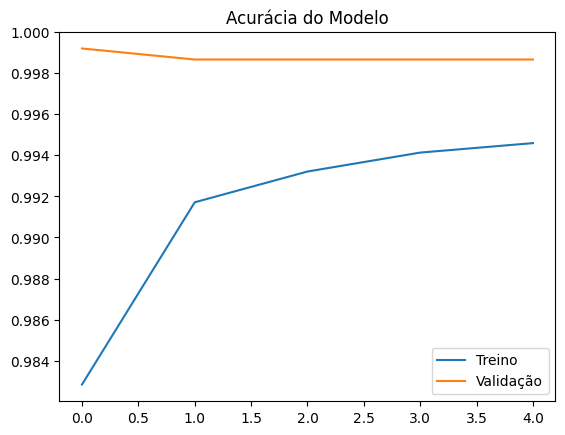

In [ ]:
plt.plot(history.history["accuracy"], label="Treino")
plt.plot(history.history["val_accuracy"], label="Validação")
plt.legend()
plt.title("Acurácia do Modelo")
plt.show()

# AVALIAÇÃO NO CONJUNTO DE TESTE
- Avalia modelo em ds_test.
- Exibe acurácia final do modelo no conjunto de teste.


In [ ]:
test_loss, test_acc = model.evaluate(ds_test)
print(f"Acurácia no conjunto de teste: {test_acc:.4f}")

117/117 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9995 - loss: 0.0017
Acurácia no conjunto de teste: 0.9987


# VISUALIZAÇÃO DE PREDIÇÕES
- Pega um batch do conjunto de teste.
- Faz predições.
- Exibe até 5 imagens com:
    - Label real (Gato/Cachorro)
    - Predição do modelo (Gato/Cachorro)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


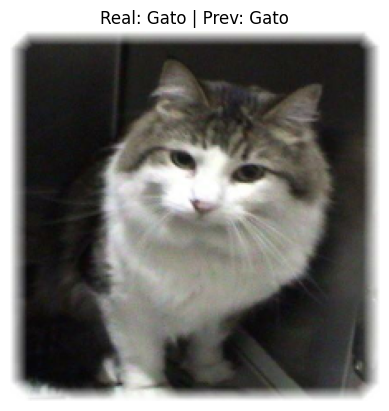

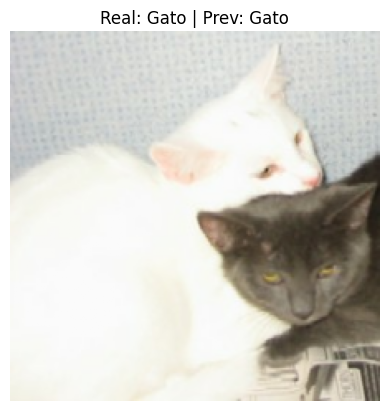

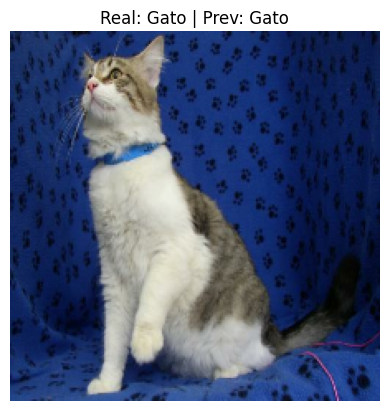

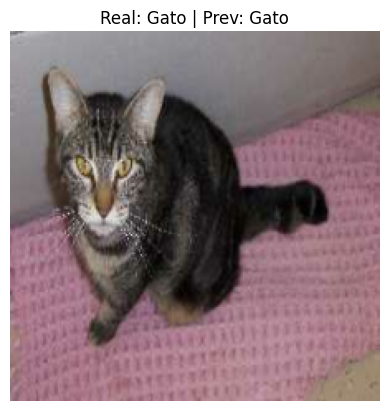

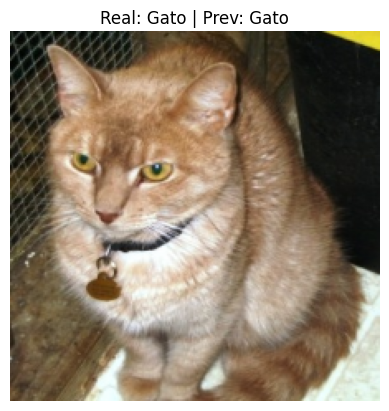

In [ ]:
for images, labels in ds_test.take(1):
    preds = model.predict(images)
    for i in range(min(5, images.shape[0])):
        plt.imshow(images[i].numpy())
        plt.title(f"Real: {'Cachorro' if labels[i].numpy()==1 else 'Gato'} | Prev: {'Cachorro' if preds[i]>0.5 else 'Gato'}")
        plt.axis("off")
        plt.show()